---
**Turma:** 15

**Grupo:** 11 - Bruno Correia, Gilson Costa, Vivian Liu

**Contato**: `brunovpm@hotmail.com, gilson.costa@gmail.com, liuoliveira.vivian@gmail.com`


**Licença deste notebook**:
![CC BY](https://licensebuttons.net/l/by/3.0/88x31.png)

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)

---
# Feature Selection

### Campos selecionados no processo abaixo
- orders_last_91d
- qtt_valid_orders
- qtt_invalid_orders
- customer_lifetime_days
- rfv_score
- merchant_variety
- merchant_offer
- total_send
- total_bounce
- total_click
- sum_event_open
- label_last_month

In [0]:
root_dir = '/dbfs/FileStore/ifood'

dbutils.fs.ls(f'{root_dir}')

Out[1]: [FileInfo(path='dbfs:/dbfs/FileStore/ifood/abt/', name='abt/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/customer_segmentation/', name='customer_segmentation/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/enrich/', name='enrich/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/marketing_push_full/', name='marketing_push_full/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders/', name='orders/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders_with_cost_revenue/', name='orders_with_cost_revenue/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/preprocess/', name='preprocess/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/sessions_visits/', name='sessions_visits/', size=0)]

### Load ABT Train Test

In [0]:
abt = 'abt_case_aug_half_end'

df_abt_case_train = spark.read.parquet(
  f'{root_dir}/abt/{abt}_train'
).repartition(2).cache()
df_abt_case_train.createOrReplaceTempView(f'{abt}_train')
df_abt_case_train.createOrReplaceTempView('abt_train')

df_abt_case_test = spark.read.parquet(
  f'{root_dir}/abt/{abt}_test'
).repartition(2).cache()
df_abt_case_test.createOrReplaceTempView(f'{abt}_test')
df_abt_case_test.createOrReplaceTempView('abt_test')

df_abt_case_train.count(), df_abt_case_test.count()

Out[2]: (21036, 9043)

### VectorAssembler

In [0]:
from pyspark.ml.feature import VectorAssembler

def assemblerTrainTest(blacklist = [], whitelist = []):
  if len(blacklist):
    featureList = [c for c in df_abt_case_train.columns if c not in blacklist]

  if len(whitelist):
    featureList = [c for c in df_abt_case_train.columns if c in whitelist]

  assembler = VectorAssembler(inputCols=featureList, outputCol = 'features')

  dfAssemblerTrain = assembler.transform(df_abt_case_train).cache()
  dfAssemblerTest  = assembler.transform(df_abt_case_test).cache()

  return dfAssemblerTrain, dfAssemblerTest, featureList

# Verificando a correlação dos campos

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.stat import Correlation

plt.rcParams['figure.figsize'] = 14, 12

def plotCorrelation(df, featureList, method = 'pearson'):
  r1 = Correlation.corr(df, 'features').head()

  pdCorr = pd.DataFrame(
    r1[0].toArray(),
    columns=featureList
  )

  pdCorr['index'] = featureList

  correlation = pdCorr.set_index('index')

  triangulo = correlation.where(np.tril(np.ones(correlation.shape), k=-1).astype(np.bool))

  # Criando uma representação gráfica para a matriz de correlação
  sns.heatmap(
    triangulo, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    annot=True
  )

  plt.title('Correlation - {}'%(method))

  plt.show()

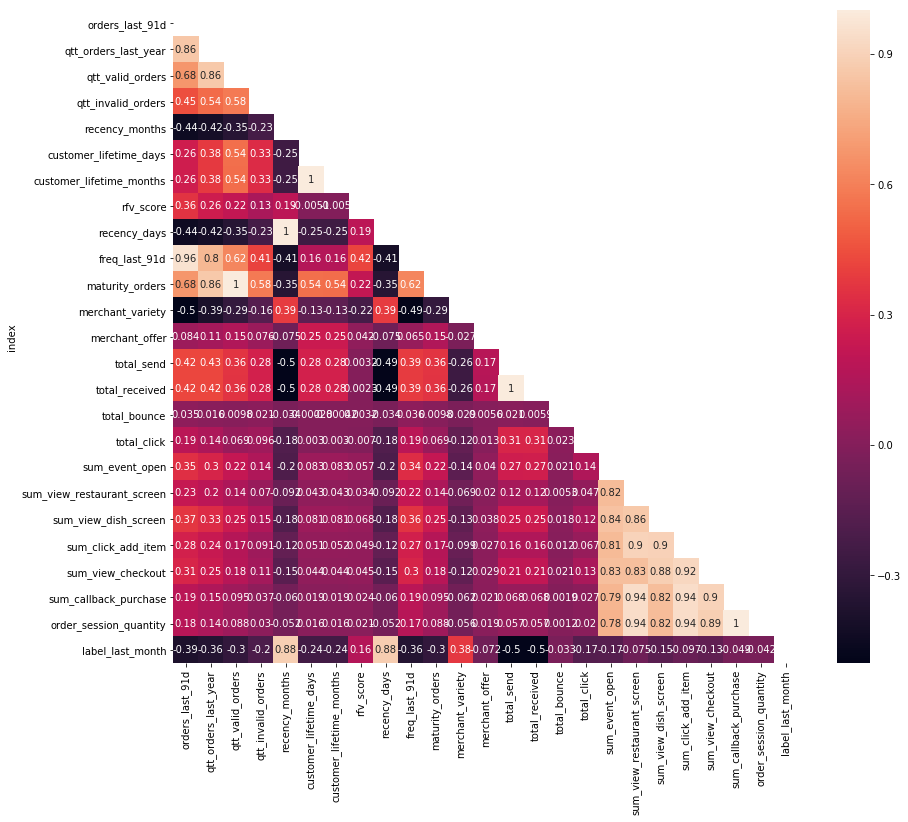

In [0]:
dfAssemblerTrain, dfAssemblerTest, featureList = assemblerTrainTest(['label', 'customer_id', 'was_mub_last_month', 'buyer_last_91d'])

plotCorrelation(dfAssemblerTrain, featureList)

### Retirando as váriáveis
- total_received
- sum_view_checkout
- sum_dish_screen

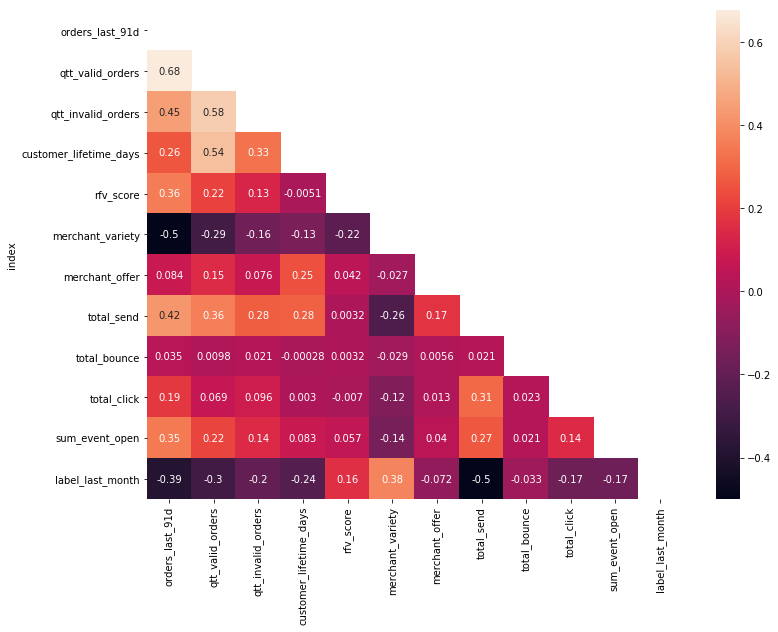

In [0]:
dfAssemblerTrain, dfAssemblerTest, featureList = assemblerTrainTest([
  'label', 'customer_id', 'was_mub_last_month', 'buyer_last_91d', 'total_received', 'sum_view_checkout', 'sum_view_dish_screen', 'maturity_order', 'freq_last_91d', 'sum_click_add_item', 'sum_view_restaurant', 'order_session_quantity', 'sum_callback_purchase', 'sum_view_restaurant_screen',
 'recency_months', 'customer_lifetime_months', 'maturity_orders','qtt_orders_last_year', "recency_days"
])

plotCorrelation(dfAssemblerTrain, featureList)

## Feature Selection Embarcado

In [0]:
import pandas as pd
from pyspark.ml.classification import GBTClassifier

def getFeatureImportancesAsPandas(model):
  pdFeatureImportance = pd.DataFrame()
  pdFeatureImportance['columns'] = featureList
  pdFeatureImportance['importance'] = model.featureImportances
  
  return pdFeatureImportance.sort_values('importance', ascending=False).round(6)

In [0]:
dfAssemblerTrain, dfAssemblerTest, featureList = assemblerTrainTest(whitelist = [
  'orders_last_91d', 'qtt_valid_orders', 'qtt_invalid_orders', 'customer_lifetime_days', 'rfv_score', 'merchant_variety', 'merchant_offer', 'total_send', 'total_bounce', 'total_click', 'sum_event_open', 'label_last_month'
])

gradientBoosting = GBTClassifier()
gradientBoostingModel = gradientBoosting.fit(dfAssemblerTrain)
getFeatureImportancesAsPandas(gradientBoostingModel)

,columns,importance
10,sum_event_open,0.726261
1,qtt_valid_orders,0.050643
0,orders_last_91d,0.048765
6,merchant_offer,0.037618
7,total_send,0.032063
3,customer_lifetime_days,0.029376
4,rfv_score,0.016529
11,label_last_month,0.014224
8,total_bounce,0.012916
2,qtt_invalid_orders,0.011282
